# Traitement des données textuelles: Cas pratique



Dieynaba KA

Jean Pierre Adiouma NDIAYE

Nicolas LOUGUE

Amadou IBRAHIM SOULEYMANE

Ousseynou GUEYE


# Introduction

Dans cette partie dédiée au traitement automatique du langage, l'objectif est de construire une représentation simplifiée et exploitable du langage naturel par une machine.

Le traitement automatique du langage naturel, souvent désigné par l’acronyme NLP (Natural Language Processing), correspond à un ensemble de techniques permettant d’analyser des textes dans le but d’en extraire des informations à l’aide d’approches statistiques ou algorithmiques. Cette discipline couvre un large éventail d’applications comme la traduction automatique, l’analyse des opinions, la recommandation de contenus ou encore la surveillance d’informations.

Une étape clé de ces approches consiste à transformer un texte, compréhensible pour un être humain, en une représentation numérique, exploitable par les modèles d’analyse automatique.

Cependant, cette conversion du langage en données chiffrées représente un véritable défi. Les textes sont par nature non structurés : les informations utiles peuvent être disséminées au sein d’un contenu dense, et leur interprétation dépend fortement du contexte (un mot peut avoir plusieurs sens selon la situation).

À ces difficultés s’ajoutent plusieurs caractéristiques propres aux données textuelles :
– Elles peuvent contenir du bruit (fautes de frappe, erreurs d’orthographe, etc.)
– Elles sont en constante évolution (apparition de nouveaux termes ou de nouveaux usages)
– Leur structure grammaticale est variée et parfois complexe
– Elles présentent des ambiguïtés (mots à sens multiples, synonymes, implicites)
– Chaque langue possède ses spécificités, ce qui rend les traitements difficilement transférables
– Enfin, elles sont souvent de très grande dimension, en raison du nombre élevé de combinaisons possibles entre les mots



## Méthode

L’analyse de texte consiste à convertir le texte en données numériques. Cela nécessite de définir une unité de base, appelée token, qui peut être un mot, un groupe de mots (n-gramme) ou une séquence de caractères.

Selon l’objectif, on applique ensuite des méthodes comme la classification ou le clustering. Mais un nettoyage préalable du texte est essentiel, sans quoi les algorithmes risquent de produire des résultats peu pertinents.

Voici les bibliothèques utiles pour ce chapitre :

In [125]:
!pip install pywaffle
!pip install spacy
!pip install plotnine
!pip install great_tables
!pip install wordcloud

# Bases d’exemple



## Le Comte de Monte Cristo

Le texte utilisé ici est Le Comte de Monte-Cristo d’Alexandre Dumas, accessible gratuitement sur le site Project Gutenberg, comme de nombreux ouvrages du domaine public.

La méthode la plus simple pour l’importer consiste à utiliser le package requests afin de télécharger le fichier, puis à le nettoyer légèrement pour extraire uniquement le contenu du livre.

In [126]:
import requests
import re

url = "https://www.gutenberg.org/files/17989/17989-0.txt"
response = requests.get(url)
response.encoding = 'utf-8'  # Assure le bon décodage
raw = response.text

dumas = (
  raw
  .split("*** START OF THE PROJECT GUTENBERG EBOOK 17989 ***")[1]
  .split("*** END OF THE PROJECT GUTENBERG EBOOK 17989 ***")[0]
)


def clean_text(text):
    text = text.lower() # mettre les mots en minuscule
    text = " ".join(text.split())
    return text

dumas = clean_text(dumas)

dumas[10000:10500]

" mes yeux. --vous avez donc vu l'empereur aussi? --il est entré chez le maréchal pendant que j'y étais. --et vous lui avez parlé? --c'est-à-dire que c'est lui qui m'a parlé, monsieur, dit dantès en souriant. --et que vous a-t-il dit? --il m'a fait des questions sur le bâtiment, sur l'époque de son départ pour marseille, sur la route qu'il avait suivie et sur la cargaison qu'il portait. je crois que s'il eût été vide, et que j'en eusse été le maître, son intention eût été de l'acheter; mais je lu"

## Le corpus anglo-saxon

La base utilisée contient des textes en anglais provenant de trois auteurs emblématiques de la littérature fantastique :

– Edgar Allan Poe (EAP)
– H. P. Lovecraft (HPL)
– Mary Shelley (MWS)

Les données sont disponibles sur un CSV mis à disposition sur GitHub (https://github.com/Jeanpierreadioumandiaye/traitements_donnees/blob/main/spooky.csv).

Le fait d’avoir un corpus confrontant plusieurs auteurs nous permettra de comprendre la manière dont les nettoyages de données textuelles favorisent les analyses comparatives.

Nous pouvons utiliser le code suivant pour lire et préparer ces données:

In [127]:
import pandas as pd

url='https://raw.githubusercontent.com/Jeanpierreadioumandiaye/traitements_donnees/refs/heads/main/spooky.csv'
#1. Import des données
horror = pd.read_csv(url,encoding='latin-1')
#2. Majuscules aux noms des colonnes
horror.columns = horror.columns.str.capitalize()
#3. Retirer le prefixe id
horror['ID'] = horror['Id'].str.replace("id","")
horror = horror.set_index('Id')

``` python
```

Le jeu de données met ainsi en regard un auteur avec une phrase qu’il a écrite :

In [128]:
horror.head()

,Text,Author,ID
Id,,,
id26305,"This process, however, afforded me no means of...",EAP,26305
id17569,It never once occurred to me that the fumbling...,HPL,17569
id11008,"In his left hand was a gold snuff box, from wh...",EAP,11008
id27763,How lovely is spring As we looked from Windsor...,MWS,27763
id12958,"Finding nothing else, not even gold, the Super...",HPL,12958


On peut se rendre compte que les extraits des 3 auteurs ne sont
pas forcément équilibrés dans le jeu de données.


<Axes: ylabel='Author'>

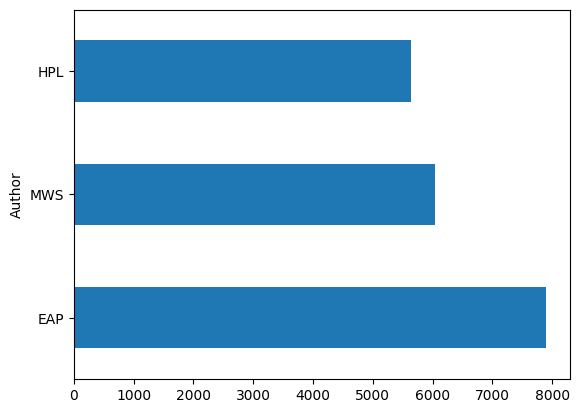

In [129]:
(
  horror
  .value_counts('Author')
  .plot(kind = "barh")
)

# Premières analyses de fréquence

Comme en statistique classique, l’analyse textuelle commence par une phase descriptive visant à explorer la structure du corpus. Cette étape permet de mieux comprendre les données avant toute modélisation.

Avant d'étudier le vocabulaire propre à chaque auteur, on commence ici par se concentrer sur un mot en particulier : fear.

## Exploration ponctuelle

On commence l’analyse en se concentrant sur le corpus en anglais, centré sur le registre de l’horreur.

L’objectif est de compter, pour chaque auteur, le nombre de phrases contenant le mot fear.
Une visualisation synthétique sera ensuite produite à l’aide de la bibliothèque pywaffle, afin de comparer ces fréquences par auteur.

L’analyse sera ensuite répétée avec le mot horror.

Nombre de phrases contenant 'fear' par auteur:
Author
EAP     70
HPL    163
MWS    215
Name: Text, dtype: int64


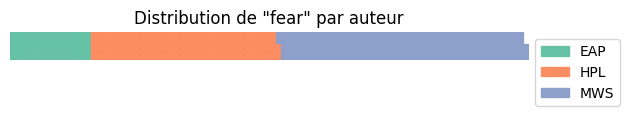

In [130]:
# Dans un premier temps, nous allons nous concentrer sur notre corpus anglo-saxon (horror)
# Compter le nombre de phrases, pour chaque auteur, où apparaît le mot fear.
# Utiliser pywaffle pour obtenir les graphiques ci-dessous qui résument de manière synthétique le nombre d’occurrences du mot “fear” par auteur.
# Refaire l’analyse avec le mot “horror”.

from pywaffle import Waffle
import matplotlib.pyplot as plt

# Function to count sentences containing a specific word for each author
def count_word_in_sentences(df, word):
  """
  Compte le nombre de phrases contenant un mot donné pour chaque auteur.

  Arguments :

  df : DataFrame pandas contenant les colonnes 'Author' et 'Text'.

  word : Mot à rechercher dans les textes.
  """
  # Ensure the 'Text' column is treated as strings and handle potential NaNs
  df['Text'] = df['Text'].astype(str)
  # Lowercase the word to make the search case-insensitive
  word_lower = word.lower()
  # Count sentences containing the word (case-insensitive)
  counts = df.groupby('Author')['Text'].apply(lambda x: x.str.lower().str.contains(word_lower).sum())
  return counts

# Function to create a waffle chart
def create_waffle_chart(counts, title):
  """
  Crée un graphique en "waffle" à partir des décomptes fournis.

  Arguments :

  counts : Series pandas avec les auteurs en index et les valeurs à représenter.

  title : Titre du graphique.
  """
  data = counts.to_dict()
  fig = plt.figure(
      FigureClass=Waffle,
      rows=5,
      values=data,
      legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
      title={'label': title, 'loc': 'center'}
  )
  plt.show()

# Count sentences with "fear"
fear_counts = count_word_in_sentences(horror, 'fear')
print("Nombre de phrases contenant 'fear' par auteur:")
print(fear_counts)

# Create waffle chart for "fear"
create_waffle_chart(fear_counts, 'Distribution de "fear" par auteur')



On remarque ainsi de manière très intuitive
le déséquilibre de notre jeu de données
lorsqu’on se focalise sur le terme *“peur”*
où Mary Shelley représente près de 50%
des observations.

Si on reproduit cette analyse avec le terme *“horror”*, on retrouve la figure suivante:


Nombre de phrases contenant 'horror' par auteur:
Author
EAP     63
HPL    106
MWS     59
Name: Text, dtype: int64


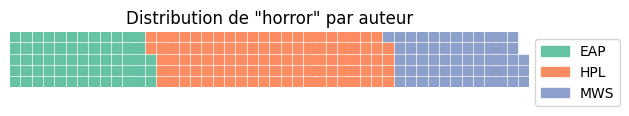

In [131]:
# Count sentences with "horror"
horror_counts = count_word_in_sentences(horror, 'horror')
print("\nNombre de phrases contenant 'horror' par auteur:")
print(horror_counts)

# Create waffle chart for "horror"
create_waffle_chart(horror_counts, 'Distribution de "horror" par auteur')

## Transformation d’un texte en *tokens*

Dans l’exemple précédent, nous faisions une recherche ponctuelle, qui ne passe pas vraiment à l’échelle. Pour généraliser cette approche, on découpe généralement un corpus en unités sémantiques indépendantes : les *tokens*.

Pour récupérer tous nos corpus `NLTK` prêts à l’emploi, nous faisons

In [132]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('genesis')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package genesis to /root/nltk_data...
[nltk_data]   Package genesis is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

En ce qui concerne `SpaCy`, il est nécessaire d’utiliser
la ligne de commande:

In [133]:
!python -m spacy download fr_core_news_sm
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 92.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 102.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Plutôt que d’implémenter soi-même un *tokenizer* inefficace, il est plus approprié d’en appliquer un issu d’une librairie spécialisée. Historiquement, le plus simple était de prendre le *tokenizer* de `NLTK`, la librairie historique de *text mining* en `Python`:

In [134]:
from nltk.tokenize import word_tokenize
word_tokenize(dumas[10000:10500])

['mes',
 'yeux',
 '.',
 '--',
 'vous',
 'avez',
 'donc',
 'vu',
 "l'empereur",
 'aussi',
 '?',
 '--',
 'il',
 'est',
 'entré',
 'chez',
 'le',
 'maréchal',
 'pendant',
 'que',
 'j',
 "'",
 'y',
 'étais',
 '.',
 '--',
 'et',
 'vous',
 'lui',
 'avez',
 'parlé',
 '?',
 '--',
 "c'est-à-dire",
 'que',
 "c'est",
 'lui',
 'qui',
 'm',
 "'",
 'a',
 'parlé',
 ',',
 'monsieur',
 ',',
 'dit',
 'dantès',
 'en',
 'souriant',
 '.',
 '--',
 'et',
 'que',
 'vous',
 'a-t-il',
 'dit',
 '?',
 '--',
 'il',
 'm',
 "'",
 'a',
 'fait',
 'des',
 'questions',
 'sur',
 'le',
 'bâtiment',
 ',',
 'sur',
 "l'époque",
 'de',
 'son',
 'départ',
 'pour',
 'marseille',
 ',',
 'sur',
 'la',
 'route',
 "qu'il",
 'avait',
 'suivie',
 'et',
 'sur',
 'la',
 'cargaison',
 "qu'il",
 'portait',
 '.',
 'je',
 'crois',
 'que',
 "s'il",
 'eût',
 'été',
 'vide',
 ',',
 'et',
 'que',
 "j'en",
 'eusse',
 'été',
 'le',
 'maître',
 ',',
 'son',
 'intention',
 'eût',
 'été',
 'de',
 "l'acheter",
 ';',
 'mais',
 'je',
 'lu']

La librairie utilisée ici montre certaines limites dans la découpe des mots : par exemple, j’y étais est découpé en plusieurs éléments ([‘j’, “‘”, ‘y’, ‘étais’]), tandis que l’acheter est conservé en un seul.

Ces incohérences s'expliquent par le fait que NLTK est principalement conçue pour l’anglais, et son algorithme de tokenisation n’est pas toujours adapté aux spécificités du français.

Pour des langues non anglophones, SpaCy constitue une alternative plus appropriée. Elle propose un découpage plus fin et mieux calibré pour les règles grammaticales du français. De plus, sa documentation est claire et bien fournie, ce qui en fait un outil recommandé pour ce type de traitement.

In [135]:
import spacy
from spacy.tokenizer import Tokenizer
nlp = spacy.load("fr_core_news_sm")
doc = nlp(dumas[10000:10500])

text_tokenized = []
for token in doc:
    text_tokenized += [token.text]

", ".join(text_tokenized)

" , mes, yeux, ., --vous, avez, donc, vu, l', empereur, aussi, ?, --il, est, entré, chez, le, maréchal, pendant, que, j', y, étais, ., --et, vous, lui, avez, parlé, ?, --c', est, -, à, -, dire, que, c', est, lui, qui, m', a, parlé, ,, monsieur, ,, dit, dantès, en, souriant, ., --et, que, vous, a, -t, -il, dit, ?, --il, m', a, fait, des, questions, sur, le, bâtiment, ,, sur, l', époque, de, son, départ, pour, marseille, ,, sur, la, route, qu', il, avait, suivie, et, sur, la, cargaison, qu', il, portait, ., je, crois, que, s', il, eût, été, vide, ,, et, que, j', en, eusse, été, le, maître, ,, son, intention, eût, été, de, l', acheter, ;, mais, je, lu"

Comme on peut l’observer, le corpus contient encore de nombreux éléments indésirables, notamment la ponctuation, qui nuisent à une structuration propre des textes. Heureusement, ces éléments pourront être facilement éliminés par la suite.

## Le nuage de mot: une première analyse généralisée

À ce stade, nous n’avons pas encore de vision claire de la composition du corpus : fréquence des mots, volume de vocabulaire, etc.

Pour obtenir un premier aperçu, on peut analyser la distribution des mots dans le texte de Dumas. On s’intéresse ici aux 30 000 premiers mots de l’œuvre, et on en extrait le nombre de mots uniques.

In [136]:
from collections import Counter

doc = nlp(dumas[:30000])

# Extract tokens, convert to lowercase and filter out punctuation and spaces
tokens = [token.text.lower() for token in doc if not token.is_punct and not token.is_space]

# Count the frequency of each token
token_counts = Counter(tokens)

Nous avons déjà de nombreux mots différents dans le début de l’oeuvre.

In [137]:
len(token_counts)

1401

Nous voyons la haute dimensionnalité du corpus puisque nous avons 1401 mots différents sur les 30 000 premiers mots de l’oeuvre de Dumas.

In [138]:
token_count_all = list(token_counts.items())

# Create a DataFrame from the list of tuples
token_count_all = pd.DataFrame(token_count_all, columns=['word', 'count'])

En examinant la distribution des fréquences des mots — un point que nous approfondirons plus tard avec la [loi de Zipf](https://fr.wikipedia.org/wiki/Loi_de_Zipf) — on constate que beaucoup de mots n’apparaissent qu’une seule fois, représentant près de la moitié du vocabulaire.

La fréquence décroît rapidement, ce qui indique qu’il serait pertinent de porter une attention particulière aux mots rares, c’est-à-dire à la queue de la distribution, ce que la figure suivante ne montre pas suffisamment.

/usr/local/lib/python3.11/dist-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 42'. Pick better value with 'binwidth'.


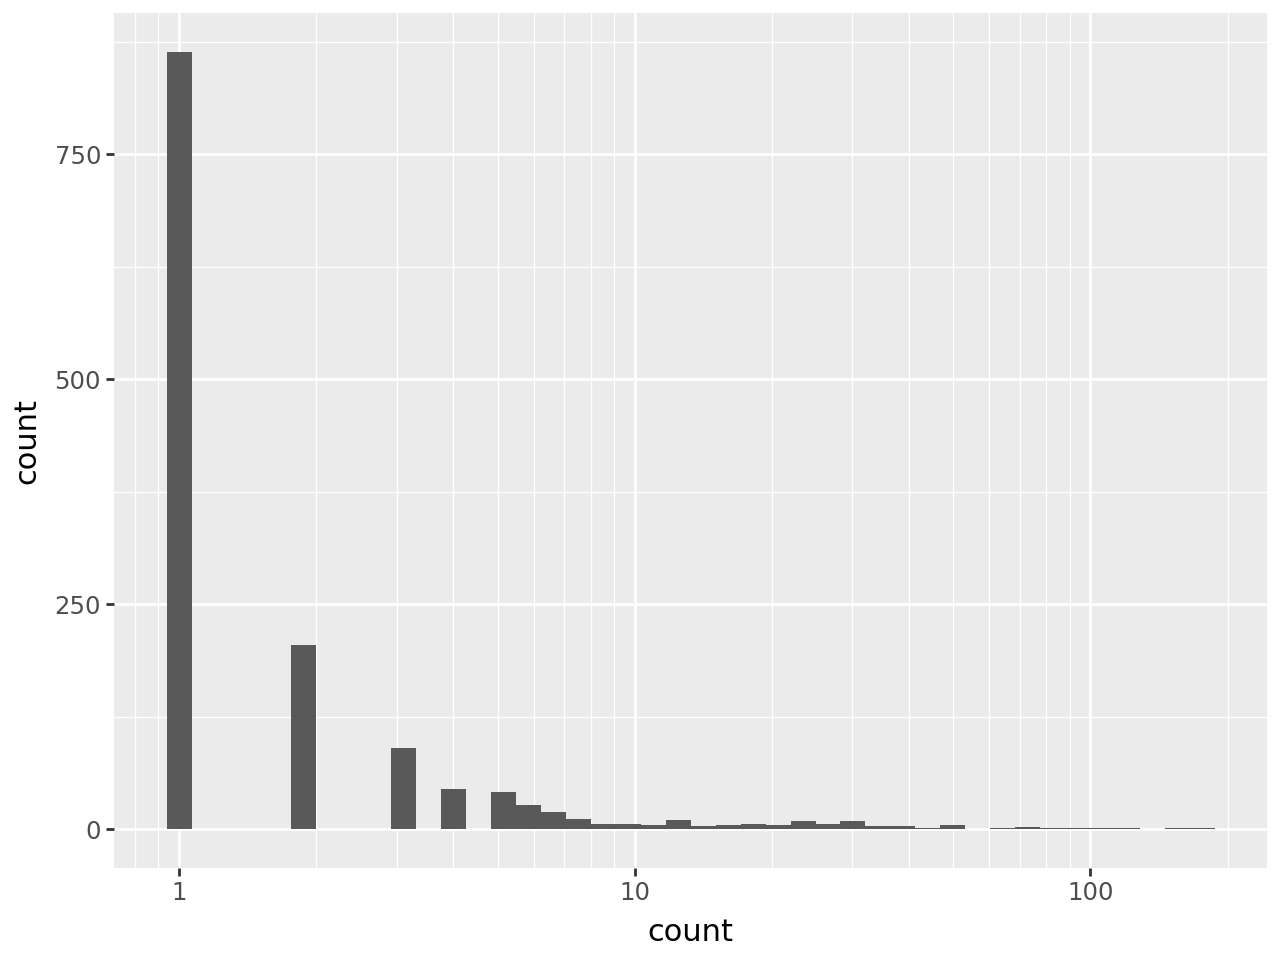

In [139]:
from plotnine import *
(
  ggplot(token_count_all) +
  geom_histogram(aes(x = "count")) +
  scale_x_log10()
)

Maintenant, si on regarde les 25 mots les plus fréquents, on peut voir que ceux-ci ne sont pas très intéressants pour analyser le sens de notre document :

In [140]:
# Sort the tokens by frequency in descending order
sorted_token_counts = token_counts.most_common(25)
sorted_token_counts = pd.DataFrame(sorted_token_counts, columns=['word', 'count'])

Si on représente graphiquement ce classement

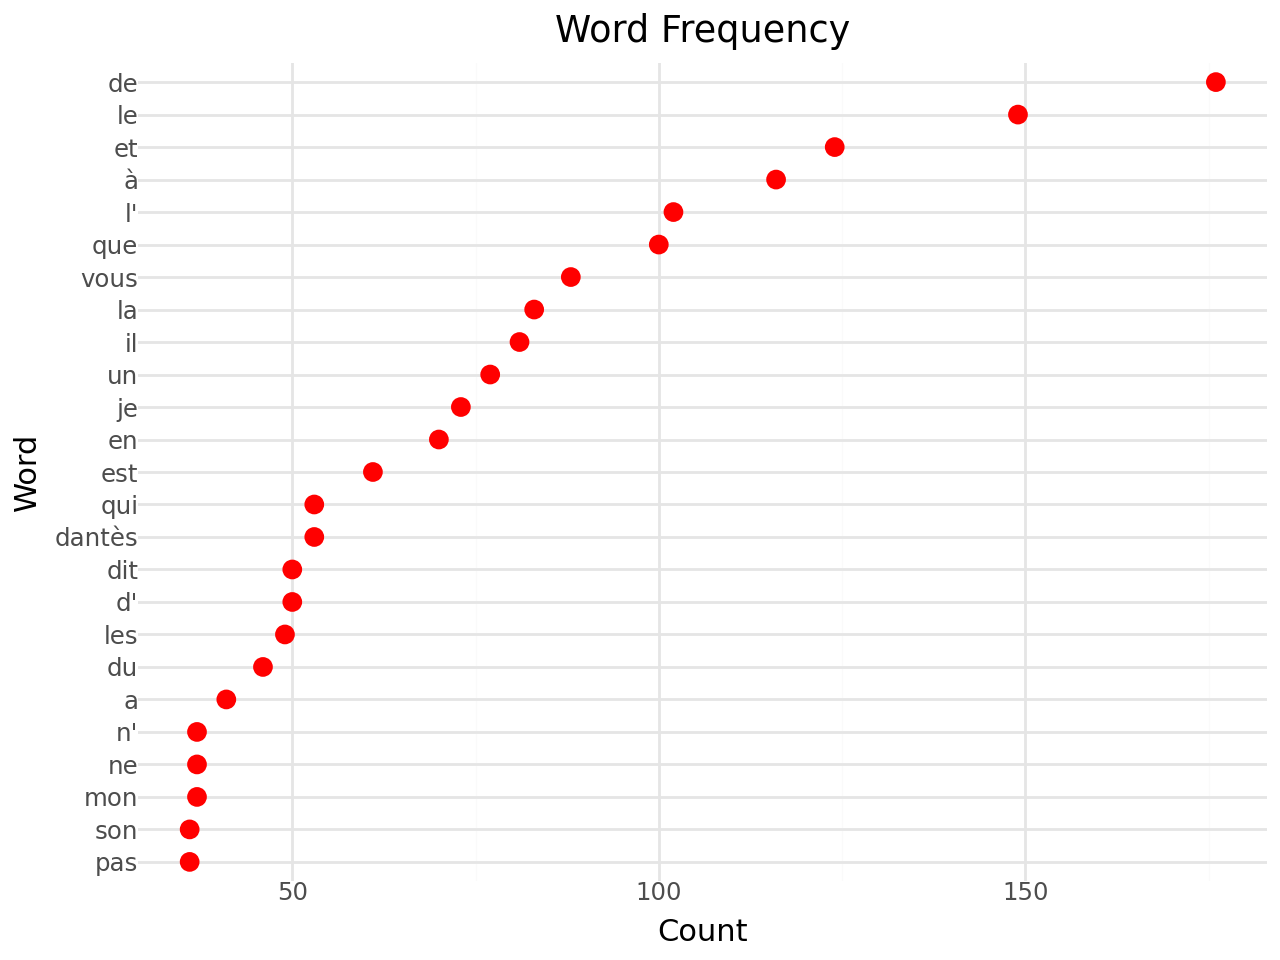

In [141]:
(
    ggplot(sorted_token_counts, aes(x='word', y='count')) +
    geom_point(stat='identity', size = 3, color = "red") +
    scale_x_discrete(
      limits=sorted_token_counts.sort_values("count")["word"].tolist()
    ) +
    coord_flip() +
    theme_minimal() +
    labs(title='Word Frequency', x='Word', y='Count')
)

Nous reviendrons plus tard sur ces mots composés, car ils jouent un rôle important dans les analyses détaillées des textes.

Ces premiers comptages nous ont donné une première idée du contenu du corpus. Cependant, une représentation plus visuelle permettrait d’affiner cette compréhension.

Les nuages de mots (wordclouds) offrent une manière efficace de visualiser les termes les plus fréquents, à condition de les utiliser de manière pertinente. En Python, le module Wordcloud facilite leur création, avec des options permettant même de personnaliser la forme du nuage selon une image donnée.
une image.



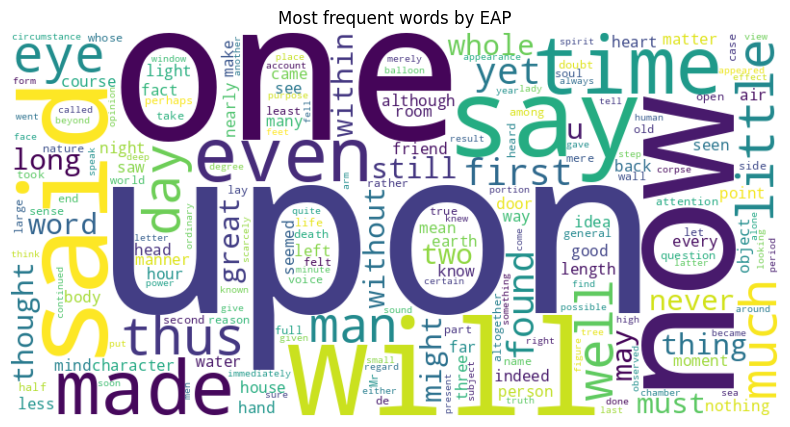

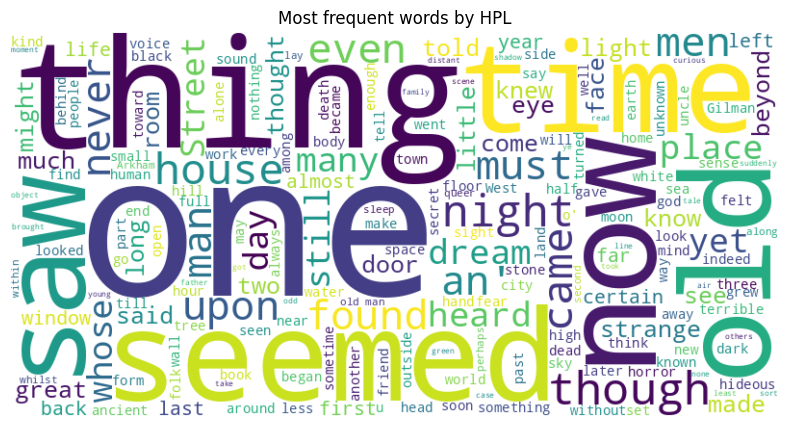

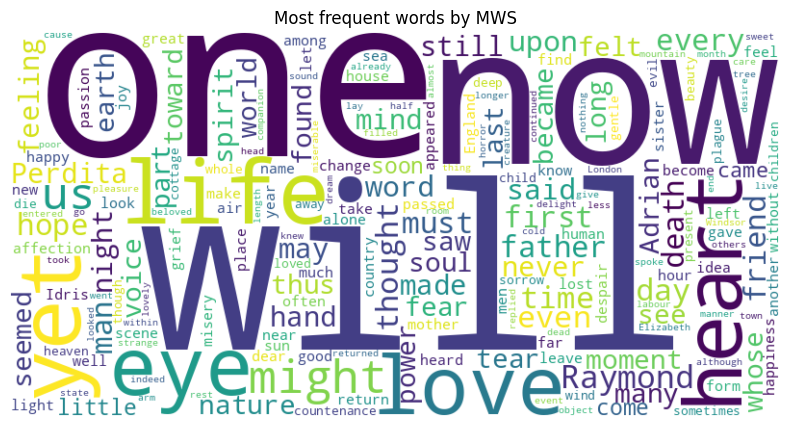

In [142]:
from wordcloud import WordCloud
import numpy as np
from PIL import Image

# 1. Wordclouds for each author in horror corpus

# Function to generate wordcloud for a given author
def generate_author_wordcloud(df, author, random_state=None):
  """
  Arguments :

  df : DataFrame pandas contenant les colonnes 'Author' et 'Text'.

  author : Nom de l’auteur à analyser.

  random_state : Graine aléatoire pour assurer la reproductibilité.
  """
  author_text = " ".join(df[df['Author'] == author]['Text'].dropna().tolist())

  wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=random_state).generate(author_text)

  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.title(f'Most frequent words by {author}')
  plt.show()

# Generate wordclouds for each author
for author in horror['Author'].unique():
  generate_author_wordcloud(horror, author, random_state=21)





Ces visualisations illustrent clairement l’importance de nettoyer les textes avant analyse.

Par exemple, dans l’œuvre de Dumas, le nom du héros, Dantès, est éclipsé par la présence fréquente d’articles et de mots de liaison qui faussent la lecture. Dans le corpus anglo-saxon, ce sont des mots courants comme « the » ou « of » qui posent le même problème.

Ces termes, appelés stop words, doivent être retirés pour obtenir une analyse plus pertinente, sauf si l’on souhaite étudier des phénomènes comme la loi de Zipf.



In [143]:
count_words = pd.DataFrame({'counter' : horror
    .groupby('Author')
    .apply(lambda s: ' '.join(s['Text']).split())
    .apply(lambda s: Counter(s))
    .apply(lambda s: s.most_common())
    .explode()}
)
count_words[['word','count']] = pd.DataFrame(count_words['counter'].tolist(), index=count_words.index)
count_words = count_words.reset_index()

count_words = count_words.assign(
    tot_mots_auteur = lambda x: (x.groupby("Author")['count'].transform('sum')),
    freq = lambda x: x['count'] /  x['tot_mots_auteur'],
    rank = lambda x: x.groupby("Author")['count'].transform('rank', ascending = False)
)

<ipython-input-143-4009929367>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


Commençons par représenter la relation entre la fréquence et le rang:

In [144]:
from plotnine import *

g = (
    ggplot(count_words) +
    geom_point(aes(y = "freq", x = "rank", color = 'Author'), alpha = 0.4) +
    scale_x_log10() + scale_y_log10() +
    theme_minimal()
)

Nous avons bien, graphiquement, une relation log-linéaire entre les deux :

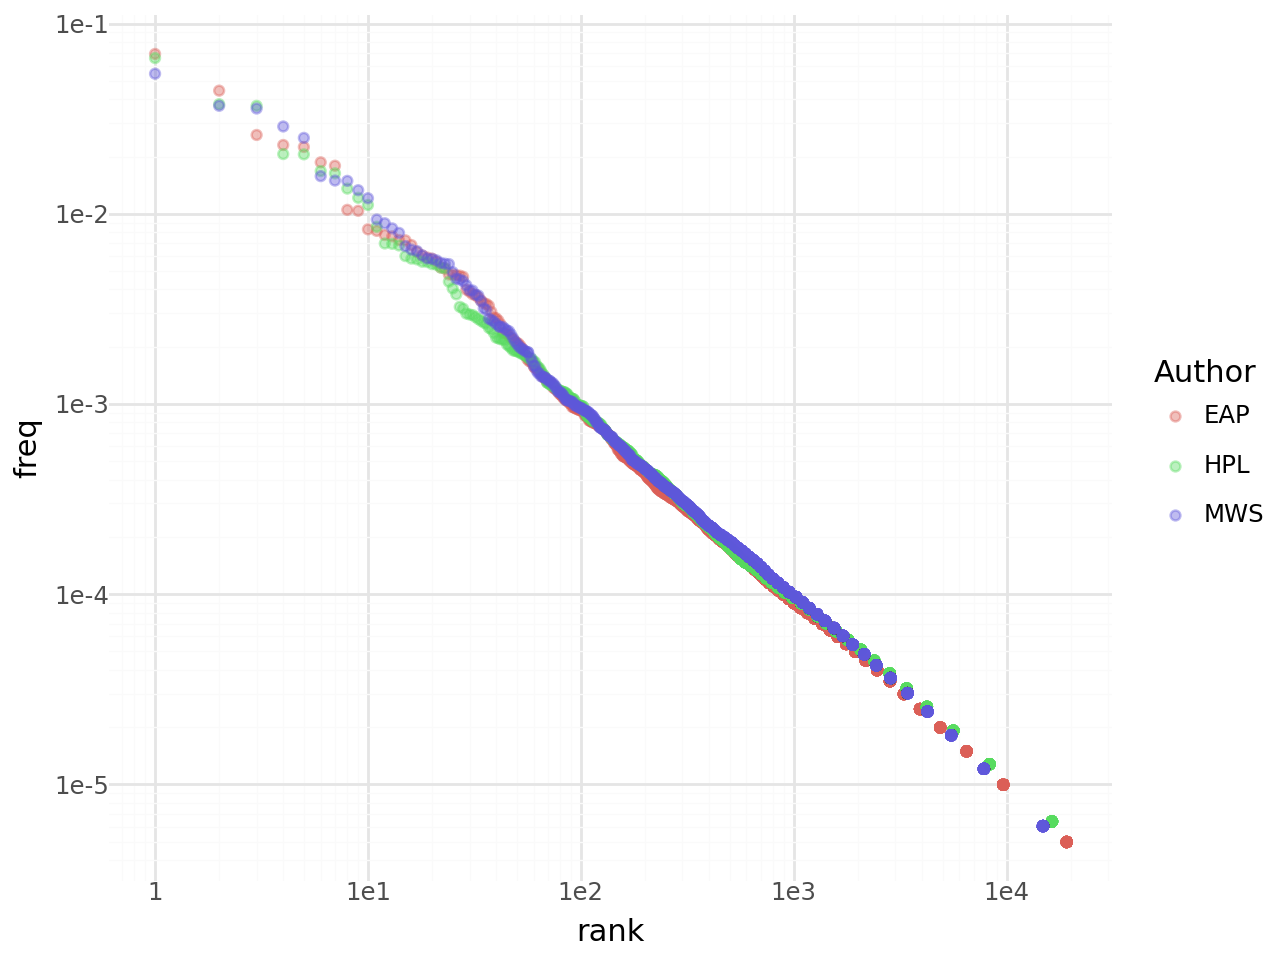

In [145]:
g

Avec `statsmodels`, vérifions plus formellement cette relation:

In [146]:
import statsmodels.api as sm
import numpy as np

exog = sm.add_constant(np.log(count_words['rank'].astype(float)))

model = sm.GLM(count_words['freq'].astype(float), exog, family = sm.families.Poisson()).fit()

# Afficher les résultats du modèle
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   freq   No. Observations:                69301
Model:                            GLM   Df Residuals:                    69299
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23.011
Date:                Sun, 15 Jun 2025   Deviance:                     0.065676
Time:                        18:23:23   Pearson chi2:                   0.0656
No. Iterations:                     5   Pseudo R-squ. (CS):          0.0002431
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4388      1.089     -2.239      0.0

Le coefficient de la régression, proche de 1, confirme l’existence d’une relation presque log-linéaire entre le rang d’un mot et sa fréquence d’apparition.

Autrement dit, le mot le plus fréquent apparaît environ deux fois plus que le second, qui lui-même est utilisé trois fois plus que le troisième, et ainsi de suite.

Cette observation correspond bien à la loi empirique que l’on retrouve ici pour ce corpus regroupant trois auteurs.

# Nettoyage de textes

## Retirer les *stop words*

Plusieurs mots de liaison, indispensables sur le plan grammatical mais peu informatifs, gênent l’identification des termes réellement porteurs de sens dans notre corpus.

Il est donc essentiel de nettoyer les textes en éliminant ces mots. Ce nettoyage dépasse le simple retrait de mots, puisqu’il inclut également la suppression d’autres éléments perturbateurs, comme la ponctuation.

Pour débuter, nous allons récupérer la liste des stopwords (mots vides) à utiliser pour ce nettoyage.

In [147]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

La liste des *stopwords* anglais dans `NLTK`
est la suivante:

In [148]:
from nltk.corpus import stopwords
", ".join(stopwords.words("english"))

"a, about, above, after, again, against, ain, all, am, an, and, any, are, aren, aren't, as, at, be, because, been, before, being, below, between, both, but, by, can, couldn, couldn't, d, did, didn, didn't, do, does, doesn, doesn't, doing, don, don't, down, during, each, few, for, from, further, had, hadn, hadn't, has, hasn, hasn't, have, haven, haven't, having, he, he'd, he'll, her, here, hers, herself, he's, him, himself, his, how, i, i'd, if, i'll, i'm, in, into, is, isn, isn't, it, it'd, it'll, it's, its, itself, i've, just, ll, m, ma, me, mightn, mightn't, more, most, mustn, mustn't, my, myself, needn, needn't, no, nor, not, now, o, of, off, on, once, only, or, other, our, ours, ourselves, out, over, own, re, s, same, shan, shan't, she, she'd, she'll, she's, should, shouldn, shouldn't, should've, so, some, such, t, than, that, that'll, the, their, theirs, them, themselves, then, there, these, they, they'd, they'll, they're, they've, this, those, through, to, too, under, until, up, 

Celle de `SpaCy` est plus riche.

In [149]:
nlp_english = spacy.load('en_core_web_sm')
stop_words_english = nlp_english.Defaults.stop_words
", ".join(stop_words_english)

"neither, so, over, himself, into, such, upon, somehow, whether, around, after, thru, wherever, otherwise, down, 've, here, another, an, anywhere, third, under, almost, without, thereupon, fifteen, if, empty, hers, never, not, though, both, us, take, seems, whereafter, mine, as, three, them, whatever, one, enough, thence, go, there, off, onto, me, no, indeed, still, forty, to, made, very, since, part, various, then, seem, was, nevertheless, itself, hereby, whither, wherein, ’ve, hereafter, keep, that, nor, by, or, whole, seemed, rather, ’m, n’t, out, the, first, five, serious, everyone, does, now, becoming, others, whose, among, other, across, n't, below, what, being, we, make, someone, for, yourself, who, somewhere, well, whenever, whoever, up, twelve, less, together, anyhow, n‘t, these, sometime, sixty, until, herself, 'm, do, top, herein, ours, becomes, ’ll, from, with, against, see, much, eleven, moreover, between, get, this, therefore, is, towards, either, yours, already, every, u

Si cette fois on prend la liste des *stopwords* français dans `NLTK`:

In [150]:
", ".join(stopwords.words("french"))

'au, aux, avec, ce, ces, dans, de, des, du, elle, en, et, eux, il, ils, je, la, le, les, leur, lui, ma, mais, me, même, mes, moi, mon, ne, nos, notre, nous, on, ou, par, pas, pour, qu, que, qui, sa, se, ses, son, sur, ta, te, tes, toi, ton, tu, un, une, vos, votre, vous, c, d, j, l, à, m, n, s, t, y, été, étée, étées, étés, étant, étante, étants, étantes, suis, es, est, sommes, êtes, sont, serai, seras, sera, serons, serez, seront, serais, serait, serions, seriez, seraient, étais, était, étions, étiez, étaient, fus, fut, fûmes, fûtes, furent, sois, soit, soyons, soyez, soient, fusse, fusses, fût, fussions, fussiez, fussent, ayant, ayante, ayantes, ayants, eu, eue, eues, eus, ai, as, avons, avez, ont, aurai, auras, aura, aurons, aurez, auront, aurais, aurait, aurions, auriez, auraient, avais, avait, avions, aviez, avaient, eut, eûmes, eûtes, eurent, aie, aies, ait, ayons, ayez, aient, eusse, eusses, eût, eussions, eussiez, eussent'

On voit que celle-ci n’est pas très riche et mériterait d’être plus complète. Celle de `SpaCy` correspond mieux à ce qu’on attend

In [151]:
stop_words_french = nlp.Defaults.stop_words
", ".join(stop_words_french)

"retour, siens, tel, parler, mes, toujours, font, huitième, sixième, ne, desquels, â, prealable, différentes, dix-neuf, si, déjà, durant, sous, revoila, hui, sa, semble, lequel, votres, bat, tres, concernant, faisaient, lesquels, différente, ils, envers, même, memes, moi, hi, l', suivantes, trente, désormais, parfois, moindres, dit, s', car, sauf, directe, exactement, telle, comment, cet, ceux, hors, se, auxquels, suivant, fais, vous-mêmes, onzième, celles-ci, très, as, elle-meme, va, afin, celui-là, facon, entre, deja, voici, antérieures, dite, nous, certaines, miens, différent, seize, peu, douzième, quelque, me, soi-meme, quoique, toi, nôtre, n', certain, t’, unes, eux, ai, y, environ, celle, les, nôtres, suit, cela, delà, avant, precisement, parle, enfin, seulement, vas, suffisant, specifique, plutôt, dès, mais, anterieure, n’, selon, cinquième, plusieurs, o, ci, moi-même, plus, certes, d', or, quelqu'un, moins, allons, la, depuis, soi-même, leurs, peut, devers, etais, vu, vers, sep

In [152]:
# Suppression des stop words

import pandas as pd
# Fonction pour nettoyer le texte (supprimer les stop words, la ponctuation, etc.)
def clean_text_with_stopwords(text, stop_words):
  """
  Nettoie un texte en supprimant les stop words, la ponctuation et les espaces.

  Arguments :

  text : Le texte à nettoyer.

  stop_words : Une liste ou un set de stop words à supprimer.
  """
  if pd.isna(text):  # Handle potential NaN values
      return ""
  doc = nlp_english(text.lower()) # Utiliser le modèle anglais de SpaCy pour le corpus horror
  tokens = [token.text for token in doc if not token.is_punct and not token.is_space and token.text not in stop_words]
  return " ".join(tokens)

# Appliquer la fonction de nettoyage au corpus horror (en anglais)
horror['Cleaned_Text'] = horror['Text'].apply(lambda x: clean_text_with_stopwords(x, stop_words_english))

# Afficher un aperçu des textes nettoyés
print("Aperçu des textes nettoyés (corpus horror):")
print(horror[['Text', 'Cleaned_Text']].head())



Aperçu des textes nettoyés (corpus horror):
                                                      Text  \
Id                                                           
id26305  This process, however, afforded me no means of...   
id17569  It never once occurred to me that the fumbling...   
id11008  In his left hand was a gold snuff box, from wh...   
id27763  How lovely is spring As we looked from Windsor...   
id12958  Finding nothing else, not even gold, the Super...   

                                              Cleaned_Text  
Id                                                          
id26305  process afforded means ascertaining dimensions...  
id17569                     occurred fumbling mere mistake  
id11008  left hand gold snuff box capered hill cutting ...  
id27763  lovely spring looked windsor terrace sixteen f...  
id12958  finding gold superintendent abandoned attempts...  


In [153]:
# Pour le corpus Dumas (en français)
dumas_cleaned = clean_text_with_stopwords(dumas, stop_words_french)
print("\nAperçu du texte de Dumas nettoyé:")
print(dumas_cleaned[:500]) # Afficher les 500 premiers caractères


Aperçu du texte de Dumas nettoyé:
comte monte cristo alexandre dumas tome 1845 1846 table matières alexandre dumas marseille.--l'arrivée ii père fils iii catalans iv complot v repas fiançailles vi substitut procureur roi vii l'interrogatoire viii château d'if ix soir fiançailles x petit cabinet tuileries xi l'ogre corse xii père fils xiii jours xiv prisonnier furieux prisonnier fou xv numéro 34 numéro 27 xvi savant italien xvii chambre l'abbé xviii trésor xix accès xx cimetière château d'if xxi l'île tiboulen xxii contrebandiers


## Racinisation et lemmatisation

Pour harmoniser un texte, on peut regrouper différentes formes d’un mot en une forme unique dite canonique, par exemple “cheval” et “chevaux”.

Deux méthodes existent :

la lemmatisation, qui utilise la grammaire pour transformer “chevaux” en “cheval” ;

le stemming, plus simple et rapide, qui coupe les mots à la racine (“chevaux” devient “chev”), mais peut créer des confusions.

In [154]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Prenons cette chaine de caractère et sa version racinisée.

In [155]:
text_string = "naples. comme d'habitude, un pilote côtier partit aussitôt du port, rasa le château d'if, et alla aborder le navire entre le cap de morgion et l'île de rion. aussitôt, co"

# Process the string with spacy
doc_string = nlp(text_string)

# Print tokens and their lemmas
for token in doc_string:
    print(f"Token: {token.text}, Lemma: {token.lemma_}")


Token: naples, Lemma: naple
Token: ., Lemma: .
Token: comme, Lemma: comme
Token: d', Lemma: de
Token: habitude, Lemma: habitude
Token: ,, Lemma: ,
Token: un, Lemma: un
Token: pilote, Lemma: pilote
Token: côtier, Lemma: côtier
Token: partit, Lemma: partit
Token: aussitôt, Lemma: aussitôt
Token: du, Lemma: de
Token: port, Lemma: port
Token: ,, Lemma: ,
Token: rasa, Lemma: raser
Token: le, Lemma: le
Token: château, Lemma: château
Token: d', Lemma: de
Token: if, Lemma: if
Token: ,, Lemma: ,
Token: et, Lemma: et
Token: alla, Lemma: aller
Token: aborder, Lemma: aborder
Token: le, Lemma: le
Token: navire, Lemma: navire
Token: entre, Lemma: entrer
Token: le, Lemma: le
Token: cap, Lemma: cap
Token: de, Lemma: de
Token: morgion, Lemma: morgion
Token: et, Lemma: et
Token: l', Lemma: le
Token: île, Lemma: île
Token: de, Lemma: de
Token: rion, Lemma: rion
Token: ., Lemma: .
Token: aussitôt, Lemma: aussitôt
Token: ,, Lemma: ,
Token: co, Lemma: co


À ce stade, les mots deviennent moins lisibles pour un humain, mais restent exploitables par la machine. Ce choix peut toutefois influencer les résultats selon le contexte d’analyse.

Les lemmatiseurs offrent une harmonisation plus fine en s’appuyant sur des bases linguistiques comme WordNet. Par exemple, des mots comme “women”, “daughters” ou “leaves” seront convertis en leur forme canonique respective.

In [156]:
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()

for word in ["women","daughters", "leaves"]:
    print(f"The lemmatized form of {word} is: {lemm.lemmatize(word)}")

The lemmatized form of women is: woman
The lemmatized form of daughters is: daughter
The lemmatized form of leaves is: leaf


# TF-IDF (Term Frequency – Inverse Document Frequency)
## Matrice document-terme
Dans l’approche du sac de mots, un texte est représenté par la fréquence d’apparition de ses mots, indépendamment de leur ordre. Bien que cette représentation soit simplifiée, elle reste utile pour extraire de l’information.

L’outil central de cette méthode est la matrice document-terme : une structure où chaque ligne correspond à un document et chaque colonne à un mot du corpus. Chaque cellule indique le nombre d’occurrences du mot dans le document.

Prenons l’exemple suivant avec trois phrases :

La pratique du tricot et du crochet

Transmettre la passion du timbre

Vivre de sa passion

La matrice associée représente alors chaque phrase par un vecteur de mots. Par exemple, la première devient [1, 0, 2, 1, 1, 0, 1, 0, 0, 0, 1, 0].

Cette représentation est dite creuse (sparse), car la majorité des éléments du vecteur sont des zéros, chaque phrase ne contenant qu’une faible portion du vocabulaire global.


## La mesure TF-IDF (*Term Frequency - Inverse Document Frequency*)

Différents documents peuvent ainsi être comparés selon la fréquence et la pertinence des mots qu'ils contiennent. C'est ce que permet la mesure **TF-IDF** (*term frequency – inverse document frequency*), couramment utilisée dans les moteurs de recherche pour évaluer la similarité entre une requête et un document.

La formule est :

$$
\text{tf-idf}(t, d, D) = \text{tf}(t, d) \times \text{idf}(t, D)
$$

où :

- \( t \) est un mot (ou terme),
- \( d \) est un document particulier,
- \( D \) est l’ensemble du corpus.

### Composantes de la mesure :

- **TF (Term Frequency)** : fréquence d'apparition du terme \( t \) dans le document \( d \), normalisée par le nombre total de mots dans \( d \) :

$$
\text{tf}(t, d) = \frac{f_{t,d}}{\sum_{t' \in d} f_{t',d}}
$$

où \( f_{t,d} \) est le nombre de fois que le mot \( t \) apparaît dans \( d \).

- **IDF (Inverse Document Frequency)** : mesure la rareté du terme dans l’ensemble des documents :

$$
\text{idf}(t, D) = \log \left( \frac{N}{|\{d \in D : t \in d\}|} \right)
$$

avec \( N \) le nombre total de documents, et le dénominateur représentant le nombre de documents contenant le terme \( t \).

Ainsi, un mot très fréquent dans un document mais rare dans le corpus obtiendra une forte pondération.

 De nombreux moteurs de recherche (comme *ElasticSearch*) utilisent ce type de mesure, ou des variantes comme **BM25**, pour évaluer la pertinence des documents vis-à-vis d’une recherche.

 ## Exemple


In [157]:
import numpy as np

# Documents d'exemple
documents = [
    "Le corbeau et le renard",
    "Rusé comme un renard",
    "Le chat est orange comme un renard"
]

# Tokenisation
def preprocess(doc):
    return doc.lower().split()

tokenized_docs = [preprocess(doc) for doc in documents]

# Term frequency (TF)
def term_frequency(term, tokenized_doc):
    term_count = tokenized_doc.count(term)
    return term_count / len(tokenized_doc)

# Inverse document frequency (DF)
def document_frequency(term, tokenized_docs):
    return sum(1 for doc in tokenized_docs if term in doc)

# Calculate inverse document frequency (IDF)
def inverse_document_frequency(word, corpus):
    # Normalisation avec + 1 pour éviter la division par zéro
    count_of_documents = len(corpus) + 1
    count_of_documents_with_word = sum([1 for doc in corpus if word in doc]) + 1
    idf = np.log10(count_of_documents/count_of_documents_with_word) + 1
    return idf

# Calculate TF-IDF scores in each document
def tf_idf_term(term):
  tf_idf_scores = pd.DataFrame(
    [
      [
      term_frequency(term, doc),
      inverse_document_frequency(term, tokenized_docs)
      ] for doc in tokenized_docs
    ],
    columns = ["TF", "IDF"]
  )
  tf_idf_scores["TF-IDF"] = tf_idf_scores["TF"] * tf_idf_scores["IDF"]
  return tf_idf_scores

Commençons par calculer TF-IDF du mot “chat” pour chaque document. De manière naturelle, c’est le troisième document, le seul où apparaît le mot qui a la valeur maximale :

In [158]:
tf_idf_term("chat")

,TF,IDF,TF-IDF
0,0.000000,1.30103,0.000000
1,0.000000,1.30103,0.000000
2,0.142857,1.30103,0.185861


In [159]:
tf_idf_term("renard")

,TF,IDF,TF-IDF
0,0.200000,1.0,0.200000
1,0.250000,1.0,0.250000
2,0.142857,1.0,0.142857


## Application (Vectorisation)

L’exemple précédent ne passait pas très bien à l’échelle.`Scikit` propose une implémentation de la recherche par vecteur TF-IDF que nous exporons.

1.  Nous allons utiliser le vectoriseur TF-IdF de `scikit-learn` pour transformer notre corpus en une matrice `document x terms`, utiliser l’option `stop_words` pour ne pas provoquer une inflation de la taille de la matrice et nommer le modèle `tfidf` et le jeu entraîné `tfs`.

2.  Après avoir construit la matrice de documents x terms avec le code suivant, nous allons rechercher les lignes où les termes ayant la structure `abandon` sont non-nuls.

3.  Ensuite, nous allons trouver les 50 extraits où le score TF-IDF du mot *“fear”* est le plus élevé et l’auteur associé puis déterminer la répartition des auteurs dans ces 50 documents.

4.  Enfin, nous observerons les 10 scores où TF-IDF de *“fear”* sont les plus élevés


In [160]:

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Utiliser le vectoriseur TF-IDF
tfidf = TfidfVectorizer(stop_words=list(stop_words_english)) # Utiliser les stop words anglais
tfs = tfidf.fit_transform(horror['Cleaned_Text'])

# Afficher la forme de la matrice
print("Affichage du vectoriseur", tfidf)



/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.


Affichage du vectoriseur TfidfVectorizer(stop_words=['neither', 'so', 'over', 'himself', 'into', 'such',
                            'upon', 'somehow', 'whether', 'around', 'after',
                            'thru', 'wherever', 'otherwise', 'down', "'ve",
                            'here', 'another', 'an', 'anywhere', 'third',
                            'under', 'almost', 'without', 'thereupon',
                            'fifteen', 'if', 'empty', 'hers', 'never', ...])


In [161]:
# 2. Rechercher les lignes où les termes ayant la structure 'abandon' sont non-nuls
# Obtenir les noms des termes (colonnes)
feature_names = tfidf.get_feature_names_out()

# Trouver l'index du terme 'abandon' (et ses variantes stemmed/lemmatized si elles sont présentes)
# On recherche tous les termes qui commencent par 'abandon'
abandon_indices = [i for i, name in enumerate(feature_names) if name.startswith('abandon')]

if abandon_indices:
    print(f"\nTermes liés à 'abandon' trouvés dans le vocabulaire: {[feature_names[i] for i in abandon_indices]}")

    # Sélectionner les colonnes correspondant aux termes 'abandon'
    abandon_tfs = tfs[:, abandon_indices]

    # Identifier les lignes (documents) où au moins un de ces termes est non-nul
    # Convertir la matrice sparse en un tableau numpy pour faciliter la vérification
    abandon_tfs_dense = abandon_tfs.toarray()
    rows_with_abandon = np.where(np.sum(abandon_tfs_dense, axis=1) > 0)[0]

    print(f"\nNombre de documents contenant des termes liés à 'abandon': {len(rows_with_abandon)}")
    print("\nIndex des documents contenant des termes liés à 'abandon':")
    print(rows_with_abandon)

    # Afficher les extraits de ces documents
    print("\nExtraits de documents contenant des termes liés à 'abandon':")
    print(horror.iloc[rows_with_abandon]['Text'].tolist())

else:
    print("\nAucun terme lié à 'abandon' trouvé dans le vocabulaire.")





Termes liés à 'abandon' trouvés dans le vocabulaire: ['abandon', 'abandoned', 'abandoning', 'abandonment']

Nombre de documents contenant des termes liés à 'abandon': 48

Index des documents contenant des termes liés à 'abandon':
[    4   116   215   571   839  1042  1052  1069  2247  2317  2505  3023
  3058  3245  3380  3764  3886  4425  5289  5576  5694  6812  7500  9013
  9021  9077  9560 11229 11395 11451 11588 11827 11989 11998 12122 12158
 12189 13666 15259 16516 16524 16759 17547 18019 18072 18126 18204 18251]

Extraits de documents contenant des termes liés à 'abandon':
['Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.', 'It was in these slums along Main Street that I would find the old Georgian churches, but they were all long abandoned.', 'All in all, he became a disconcerting and even gruesome companion; yet in my gratitude for his healing I could n

In [162]:
# 3. Trouver les 50 extraits où le score TF-IDF du mot “fear” est le plus élevé et l’auteur associé
try:
    # Trouver l'index du terme 'fear'
    fear_index = tfidf.vocabulary_['fear']

    # Obtenir les scores TF-IDF pour le terme 'fear' dans tous les documents
    fear_tfidf_scores = tfs[:, fear_index].toarray().flatten()

    # Créer un DataFrame avec les scores TF-IDF et les informations sur les documents
    fear_scores_df = pd.DataFrame({
        'Author': horror['Author'],
        'Text': horror['Text'],
        'TF-IDF_fear': fear_tfidf_scores
    })

    # Trier par score TF-IDF de 'fear' par ordre décroissant
    fear_scores_df_sorted = fear_scores_df.sort_values(by='TF-IDF_fear', ascending=False)

    # Sélectionner les 50 extraits avec les scores les plus élevés (s'il y en a au moins 50)
    top_50_fear_extracts = fear_scores_df_sorted.head(50)

    print("\nTop 50 extraits avec les scores TF-IDF de 'fear' les plus élevés:")
    print(top_50_fear_extracts[['Author', 'Text', 'TF-IDF_fear']])

    # Déterminer la répartition des auteurs dans ces 50 documents
    author_distribution_top_50 = top_50_fear_extracts['Author'].value_counts()

    print("\nRépartition des auteurs dans les Top 50 extraits avec les scores TF-IDF de 'fear' les plus élevés:")
    print(author_distribution_top_50)

except KeyError:
    print("\nLe terme 'fear' n'a pas été trouvé dans le vocabulaire après le nettoyage et la vectorisation.")
except Exception as e:
    print(f"\nUne erreur est survenue lors du traitement du terme 'fear': {e}")





Top 50 extraits avec les scores TF-IDF de 'fear' les plus élevés:
        Author                                               Text  TF-IDF_fear
Id                                                                            
id19365    MWS                      We could not fear we did not.     1.000000
id21042    MWS                      "And now I do not fear death.     0.739286
id19372    EAP                      Be of heart and fear nothing.     0.736398
id09720    EAP               Indeed I had no fear on her account.     0.667112
id22562    EAP                  I smiled, for what had I to fear?     0.578996
id19415    HPL  I did not like everything about what I saw, an...     0.548124
id18002    MWS  At length, in an abrupt manner she asked, "Whe...     0.489489
id09240    EAP      I have not the slightest fear for the result.     0.485122
id09809    EAP    "I fear you are right there," said the Prefect.     0.462242
id06566    EAP  I went down to open it with a light heart, for..

In [163]:
# 4. Observer les 10 scores où TF-IDF de “fear” sont les plus élevés
try:
    if 'fear_scores_df_sorted' in locals():
        # Sélectionner les 10 scores les plus élevés
        top_10_fear_scores = fear_scores_df_sorted.head(10)

        print("\nTop 10 scores TF-IDF de 'fear':")
        print(top_10_fear_scores[['Author', 'TF-IDF_fear']])
    else:
        print("\nLes scores TF-IDF pour 'fear' n'ont pas pu être calculés.")

except Exception as e:
     print(f"\nUne erreur est survenue lors de l'observation des 10 scores les plus élevés: {e}")



Top 10 scores TF-IDF de 'fear':
        Author  TF-IDF_fear
Id                         
id19365    MWS     1.000000
id21042    MWS     0.739286
id19372    EAP     0.736398
id09720    EAP     0.667112
id22562    EAP     0.578996
id19415    HPL     0.548124
id18002    MWS     0.489489
id09240    EAP     0.485122
id09809    EAP     0.462242
id06566    EAP     0.454149
